In [1]:
from csv import QUOTE_NONNUMERIC

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from memote import ReportConfiguration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = 16, 9

In [6]:
colors = [
  "#A6A9AA",
  "#000000",
  "#3E7CBC",
  "#A3D2E2",
  "#DDEDF6",
  "#EDA85F",
  "#CD2028"
]

## Extract

In [7]:
bucket = []
for filename, collection in [
    ("../data/bigg.csv.gz", "bigg"),
    ("../data/uminho.csv.gz", "uminho"),
    ("../data/mmodel.csv.gz", "ebrahim"),
    ("../data/agora.csv.gz", "agora"),
    ("../data/embl_gems.csv.gz", "embl"),
    ("../data/path2models.csv.gz", "path"),
    ("../data/seed.csv.gz", "seed"),
]:
    tmp = pd.read_csv(filename)
    tmp["collection"] = collection
    bucket.append(tmp)
df = pd.concat(bucket, ignore_index=True)

In [8]:
df.shape

(1578988, 9)

In [9]:
df.head()

,test,title,section,metric,numeric,model,time,status,collection
0,test_absolute_extreme_coefficient_ratio,Ratio Min/Max Non-Zero Coefficients,matrix,0.0,2.706242e+07,iE2348C_1286,0.046556,passed,bigg
1,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,9.996578e-01,iE2348C_1286,0.000978,passed,bigg
2,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,9.999945e-01,iE2348C_1286,0.000775,passed,bigg
3,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,1.0,0.000000e+00,iE2348C_1286,0.006497,failed,bigg
4,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,9.824784e-01,iE2348C_1286,0.739684,passed,bigg


## Transform

Exclude the biomass section since it is not universally applicable and may contain multiple reactions per model. We also exclude the matrix section since that is purely informative and says nothing about the model quality.

In [10]:
df = df.loc[~df["section"].isin([
    "matrix",
    "test_biomass"
]), :]

We further exclude tests related to the biomass but from different sections.

In [11]:
df = df.loc[~df["test"].isin([
    "test_biomass_open_production",
    "test_essential_precursors_not_in_biomass",
    "test_gam_in_biomass"
]), :]

We further invalidate metric results where the numeric test result is missing.

In [12]:
df.loc[df["numeric"].isnull(), "metric"] = float("nan")

In [13]:
df["collection"].unique()

array(['bigg', 'uminho', 'ebrahim', 'agora', 'embl', 'path', 'seed'],
      dtype=object)

### Pivot Table

Each model from each collection is one observation (row) and each test case constitutes one variable or category (column) measuring model performance.

In [14]:
observations = df.set_index(["collection", "model", "test"])

Check for duplicates which will prevent unstacking.

In [15]:
observations[observations.index.duplicated(keep=False)].sort_index()

,,,title,section,metric,numeric,time,status
collection,model,test,,,,,,


In [16]:
observations = observations.loc[:, ["metric"]].unstack()
observations.head()

metric  \
test                                             test_biomass_specific_sbo_presence   
collection model                                                                      
agora      Abiotrophia_defectiva_ATCC_49176                                     1.0   
           Achromobacter_xylosoxidans_A8                                        1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                1.0   
           Acidaminococcus_fermentans_DSM_20731                                 1.0   
           Acidaminococcus_intestini_RyC_MR95                                   1.0   

                                                                         \
test                                             test_blocked_reactions   
collection model                                                          
agora      Abiotrophia_defectiva_ATCC_49176                    0.285182   
           Achromobacter_xylosoxidans_A8                       0.356715   
           Achromobacter_xylosoxidans_NBRC_15126               0.288530   
           Acidaminococcus_fermentans_DSM_20731                0.347550   
           Acidaminococcus_intestini_RyC_MR95                  0.302697   

                                                                             \
test                                             test_compartments_presence   
collection model                                                              
agora      Abiotrophia_defectiva_ATCC_49176                             0.0   
           Achromobacter_xylosoxidans_A8                                0.0   
           Achromobacter_xylosoxidans_NBRC_15126                        0.0   
           Acidaminococcus_fermentans_DSM_20731                         0.0   
           Acidaminococcus_intestini_RyC_MR95                           0.0   

                                                                                    \
test                                             test_demand_specific_sbo_presence   
collection model                                                                     
agora      Abiotrophia_defectiva_ATCC_49176                                    1.0   
           Achromobacter_xylosoxidans_A8                                       1.0   
           Achromobacter_xylosoxidans_NBRC_15126                               1.0   
           Acidaminococcus_fermentans_DSM_20731                                1.0   
           Acidaminococcus_intestini_RyC_MR95                                  1.0   

                                                                                              \
test                                             test_detect_energy_generating_cycles-MNXM10   
collection model                                                                               
agora      Abiotrophia_defectiva_ATCC_49176                                              NaN   
           Achromobacter_xylosoxidans_A8                                                 NaN   
           Achromobacter_xylosoxidans_NBRC_15126                                         NaN   
           Acidaminococcus_fermentans_DSM_20731                                          NaN   
           Acidaminococcus_intestini_RyC_MR95                                            NaN   

                                                                                               \
test                                             test_detect_energy_generating_cycles-MNXM121   
collection model                                                                                
agora      Abiotrophia_defectiva_ATCC_49176                                               NaN   
           Achromobacter_xylosoxidans_A8                                                  NaN   
           Achromobacter_xylosoxidans_NBRC_15126                                          NaN   
           Acidaminococcus_fermentans_DSM_20731                                           NaN   
         

In [17]:
observations.shape

(10828, 131)

In [18]:
observations.index.get_level_values("collection").unique()

Index(['agora', 'bigg', 'ebrahim', 'embl', 'path', 'seed', 'uminho'], dtype='object', name='collection')

### Handle Missing Values

In [19]:
observations.isna().sum(axis=0).sort_values(ascending=False)

        test                                                    
metric  test_detect_energy_generating_cycles-MNXM63                 10828
        test_detect_energy_generating_cycles-MNXM223                10828
        test_growth_from_data_qualitative-experiment0               10828
        test_gene_essentiality_from_data_qualitative-experiment0    10828
        test_detect_energy_generating_cycles-MNXM89557              10828
        test_detect_energy_generating_cycles-MNXM7517               10828
        test_detect_energy_generating_cycles-MNXM6                  10828
        test_detect_energy_generating_cycles-MNXM51                 10828
        test_detect_energy_generating_cycles-MNXM423                10828
        test_detect_energy_generating_cycles-MNXM38                 10828
        test_detect_energy_generating_cycles-MNXM3                  10828
        test_detect_energy_generating_cycles-MNXM558                10828
        test_detect_energy_generating_cycles-MN

We set the missing values equivalent to being completely wrong, i.e., metric = 1.

In [20]:
observations[observations.isna()] = 1.0

## Dimension Reduction

### PCA

In [21]:
%%time
pca = PCA(n_components=2).fit_transform(observations)

CPU times: user 388 ms, sys: 492 ms, total: 880 ms
Wall time: 166 ms


In [22]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(pca[mask, 0])
    y.extend(pca[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_pca.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

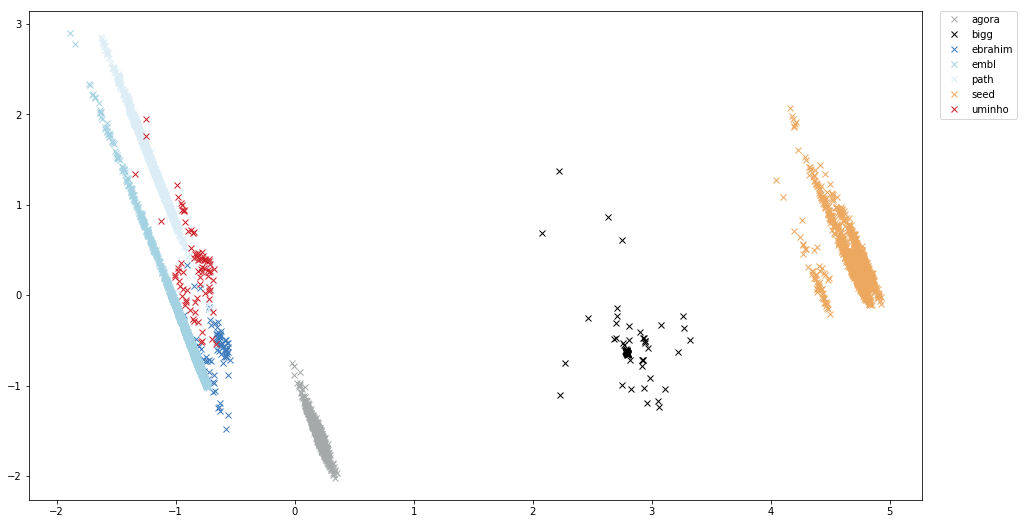

In [23]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(pca[mask, 0], pca[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### t-SNE

In [24]:
%%time
tsne = TSNE(n_components=2).fit_transform(observations)

CPU times: user 1min 22s, sys: 138 ms, total: 1min 22s
Wall time: 1min 23s


In [25]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(tsne[mask, 0])
    y.extend(tsne[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_tsne.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

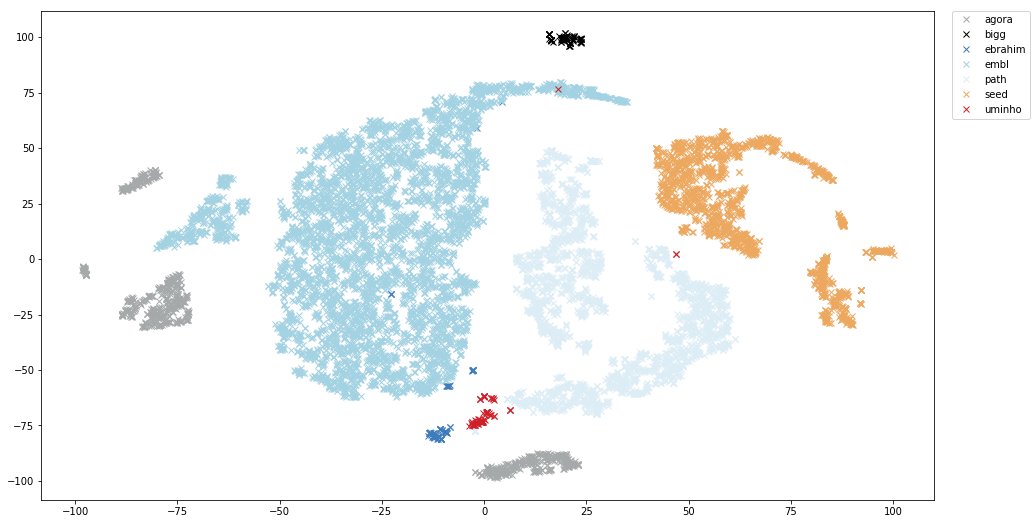

In [26]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(tsne[mask, 0], tsne[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### UMAP

In [27]:
%%time
umap = UMAP(n_components=2).fit_transform(observations)

/home/moritz/.virtualenvs/memote-meta/lib/python3.6/site-packages/umap/spectral.py:229 UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)


CPU times: user 23.6 s, sys: 3.68 s, total: 27.3 s
Wall time: 22.4 s


In [28]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(umap[mask, 0])
    y.extend(umap[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_umap.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

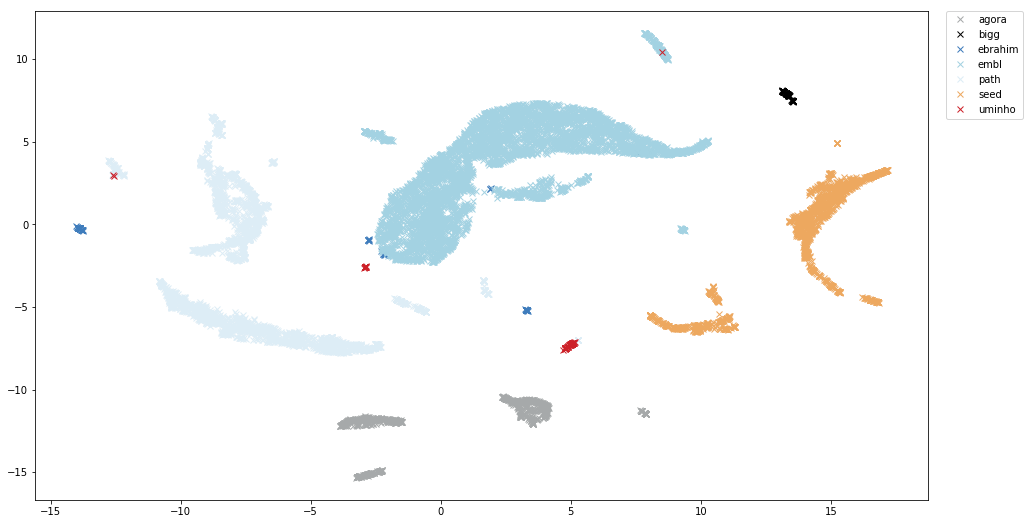

In [29]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(umap[mask, 0], umap[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()